<a href="https://colab.research.google.com/github/AuFeld/DS-Unit-2-Applied-Modeling/blob/master/module4/CGoldfeld_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
columns = ['Inspection ID', 'License #', 'Zip', 'Latitude', 'Longitude', 'Location', 'Inspection Date', 'Fail']

In [32]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
13409,327244,CHANG'S ORIENTAL EXPRESS INC,CHANG'S,26263.0,Restaurant,Risk 1 (High),3718 N ELSTON AVE,CHICAGO,IL,60618.0,2010-08-06T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.948869,-87.712340,"{'longitude': '-87.71234012217985', 'latitude'...",0
42587,2159518,B&B ICE CREAM AND CANDY,B&B ICE CREAM AND CANDY,2589149.0,Grocery Store,Risk 2 (Medium),8238 S RACINE AVE,CHICAGO,IL,60620.0,2018-04-05T00:00:00,License Re-Inspection,8. SANITIZING RINSE FOR EQUIPMENT AND UTENSILS...,41.743870,-87.653705,"{'longitude': '-87.65370482767793', 'latitude'...",1
228,2081842,THAI VALLEY RESTAURANT,THAI VALLEY RESTAURANT,83774.0,Restaurant,Risk 1 (High),4600 N KEDZIE AVE,CHICAGO,IL,60625.0,2017-09-08T00:00:00,Canvass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.964740,-87.708504,"{'longitude': '-87.70850367911711', 'latitude'...",0
40468,1277678,DUKS RED HOTS,DUKS RED HOTS,69637.0,Restaurant,Risk 2 (Medium),636 N ASHLAND AVE,CHICAGO,IL,60622.0,2013-01-30T00:00:00,Complaint Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.893513,-87.667363,"{'longitude': '-87.66736304901177', 'latitude'...",0
37472,1501941,NAF NAF GRILL,NAF NAF GRILL,2263714.0,Restaurant,Risk 1 (High),326 N MICHIGAN AVE,CHICAGO,IL,60601.0,2014-11-17T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.887415,-87.624698,"{'longitude': '-87.62469814634396', 'latitude'...",0


In [0]:
target = 'Fail'
X_train = train.drop(columns=target)
y_train = train[target]
X_test = test

In [0]:
# using ordinal encoder as my preprocessing method in the pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

In [8]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['DBA Name', 'AKA Name', 'Facility Type',
                                      'Risk', 'Address', 'City', 'State',
                                      'Inspection Date', 'Inspection Type',
                                      'Violations', 'Location'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'DBA Name',
                                          'data_type': dtype('O'),
                                          'mapping': TOM YUM RICE & NOODLE, INC.                  1
FILLING S...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                     

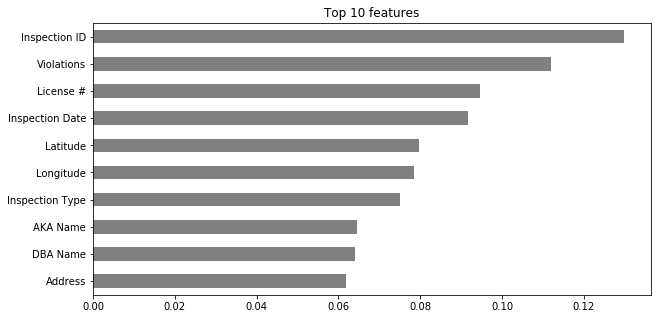

In [10]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
# split

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Fail'], random_state=42)

In [0]:
# assign variables

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [29]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7400808936825886


In [0]:
from sklearn.metrics import roc_curve
y_pred_proba = pipeline.predict_proba(X_val)[:, -1] # Probability for the last class
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [31]:
# Use scikit-learn to calculate the area under the curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.6171467527161983

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [0]:
# Eli5

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [39]:
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
import eli5
from eli5.sklearn import PermutationImportance

# 1. Calculate permutation importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [41]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

License #         -0.000924
Location          -0.000424
AKA Name          -0.000404
Risk              -0.000231
Violations        -0.000058
City               0.000000
State              0.000000
Zip                0.000327
Longitude          0.000366
Latitude           0.000944
Inspection ID      0.000963
DBA Name           0.001021
Address            0.001387
Inspection Date    0.001464
Facility Type      0.002542
Inspection Type    0.004892
dtype: float64

In [42]:
# Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0049 ± 0.0025,Inspection Type
0.0025 ± 0.0010,Facility Type
0.0015 ± 0.0018,Inspection Date
0.0014 ± 0.0013,Address
0.0010 ± 0.0013,DBA Name
0.0010 ± 0.0019,Inspection ID
0.0009 ± 0.0012,Latitude
0.0004 ± 0.0019,Longitude
0.0003 ± 0.0017,Zip
0 ± 0.0000,State


In [0]:
#PDP

features = ['Inspection Type', 'Facility Type', 'DBA Name']
X = train[features]
y = train[target]

In [52]:
# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


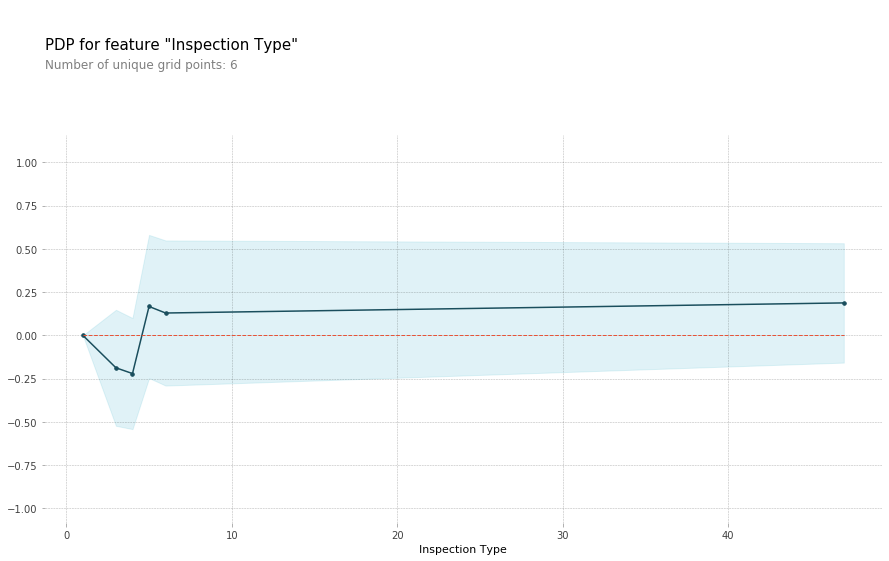

In [53]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'Inspection Type'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);